### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### Loading and cleaning the data

In [2]:
df1 = pd.read_csv('../data/voc_2010-2022.csv')
df2 = pd.read_csv('../data/HYY_META.T336_1997-01-01--9999-09-09.csv')

In [3]:
# remove from df1 other columns than monoterpene_flux
# remove from df2 Unnamed
df1 = df1.drop(columns=['Unnamed: 0', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])
df2 = df2.drop(columns=['Unnamed: 0'])

In [4]:
# Convert time labels to datetime objects
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])

In [5]:
# keep only observations occurring during 11.00-14.00 each day
df1 = df1[(df1['Datetime'].dt.hour>=11) & (df1['Datetime'].dt.hour<=14)]
df2 = df2[(df2['Datetime'].dt.hour>=11) & (df2['Datetime'].dt.hour<=14)]

In [6]:
# Keep only the measurements after start_time
# Monoterpene data should be available
START_TIME = pd.to_datetime('2010-06-01')
df1 = df1[df1['Datetime'] >= START_TIME]
df2 = df2[df2['Datetime'] >= START_TIME]

In [7]:
# use daily median from measurements between 11-14
daily_df1 = df1.resample('D', on = 'Datetime').median().reset_index()
daily_df2 = df2.resample('D', on = 'Datetime').median().reset_index()

In [8]:
# combine with temperature data, use only years when monoterpene data available (already done above)
df_combined = pd.merge(daily_df1, daily_df2, on='Datetime', how='outer')

In [9]:
# drop lines where there is missing data
df_combined = df_combined.dropna()

### Step 1

The air-temperature data used here is T336 since I didn't find the 16.8m height data

In [10]:
# calculate the EF(t)
df_combined["EF_t"] = (df_combined["monoterpene_flux"] * np.exp(0.09*(25-df_combined["HYY_META.T336"]))) 

### Step 2

In [11]:
# Calculate the E(t) for air-temperature data-set
df_combined["E_t"] = df_combined["EF_t"] / np.exp(0.09*(25-df_combined["HYY_META.T336"]))

In [12]:
# Calculate the difference between the estimate and the observation
df_combined["Difference"] = (df_combined["monoterpene_flux"] - df_combined["E_t"])

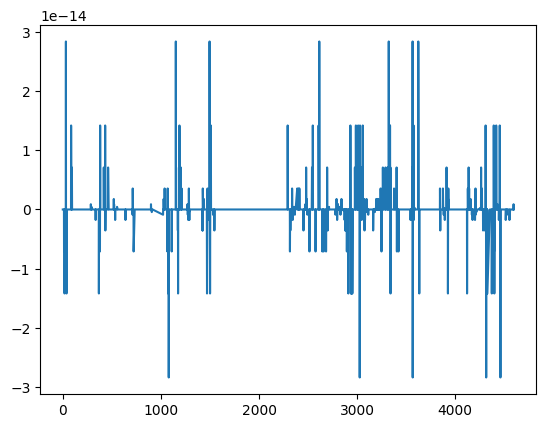

In [13]:
plt.plot(df_combined['Difference'])

The differences are very small, and it seems that there is something wrong in the calculations.

### Monoterpene baseline calculation v2

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [17]:
# Load the data
MT = pd.read_csv('./../data/voc_2010-2022.csv') # Monoterpene data
T = pd.read_csv('./../data/HYY_META.T336_1997-01-01--9999-09-09.csv') # Temperature data

In [18]:
# remove from MT other columns than monoterpene_flux
# remove from T Unnamed
MT = MT.drop(columns=['Unnamed: 0', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])
T = T.drop(columns=['Unnamed: 0'])

In [19]:

# Convert time labels to datetime objects and set an index
MT['Datetime'] = pd.to_datetime(MT['Datetime'])
MT.set_index('Datetime', inplace=True)
T['Datetime'] = pd.to_datetime(T['Datetime'])
T.set_index('Datetime', inplace=True)

In [20]:
# Keep only the measurements after start_time Monoterpene data should be available
START_TIME = pd.to_datetime('2010-06-01')
MT = MT[MT.index >= START_TIME]
T = T[T.index >= START_TIME]

In [21]:
print(MT.head())
print(MT.shape)

                     monoterpene_flux
Datetime                             
2010-06-01 05:22:00          72.18297
2010-06-01 08:22:00          32.48285
2010-06-01 11:22:00          44.32782
2010-06-01 17:22:00         138.54898
2010-06-01 20:22:00          25.00049
(15831, 1)


In [22]:
MT.tail()

,monoterpene_flux
Datetime,
2022-12-30 11:22:00,86.1430
2022-12-30 14:22:00,2.9648
2022-12-30 17:22:00,-7.1231
2022-12-30 20:22:00,-16.9710
2022-12-30 23:22:00,-36.8120


In [23]:
print(T.head())
print(T.shape)

                     HYY_META.T336
Datetime                          
2010-06-01 00:00:00          10.46
2010-06-01 00:01:00          10.33
2010-06-01 00:02:00          10.43
2010-06-01 00:03:00          10.39
2010-06-01 00:04:00          10.39
(7004789, 1)


In [24]:
T.tail()

,HYY_META.T336
Datetime,
2023-12-31 23:55:00,-17.17
2023-12-31 23:56:00,-17.02
2023-12-31 23:57:00,-17.15
2023-12-31 23:58:00,-17.10
2023-12-31 23:59:00,-17.28


Temperature data ends 2023 and monoterpene 2022. 

In [25]:
# Get the last date of the monoterpene data
END_TIME = MT.index[-1].date()

# Get the temperature data for the same period
T = T[T.index.date <= END_TIME]
T.tail()

,HYY_META.T336
Datetime,
2022-12-30 23:55:00,1.31
2022-12-30 23:56:00,1.28
2022-12-30 23:57:00,1.29
2022-12-30 23:58:00,1.27
2022-12-30 23:59:00,1.30


In [26]:
MT.tail()

,monoterpene_flux
Datetime,
2022-12-30 11:22:00,86.1430
2022-12-30 14:22:00,2.9648
2022-12-30 17:22:00,-7.1231
2022-12-30 20:22:00,-16.9710
2022-12-30 23:22:00,-36.8120


#### Step 1

In [27]:
# Filter out years with warm summers (2010, 2018, 2021) 
warm_summer_years = [2010, 2018, 2021]
filtered_MT = MT[~MT.index.year.isin(warm_summer_years)]
filtered_T = T[~T.index.year.isin(warm_summer_years)]

In [28]:
print(filtered_MT.shape)
print(filtered_T.shape)

(11741, 1)
(5147077, 1)


In [29]:
filtered_MT

,monoterpene_flux
Datetime,
2011-03-07 20:22:00,NaN
2011-03-08 11:22:00,NaN
2011-03-08 14:22:00,-4.22413
2011-03-08 17:22:00,10.00322
2011-03-08 20:22:00,-16.48562
...,...
2022-12-30 11:22:00,86.14300
2022-12-30 14:22:00,2.96480
2022-12-30 17:22:00,-7.12310


In [30]:
filtered_T

,HYY_META.T336
Datetime,
2011-01-01 00:00:00,-7.32
2011-01-01 00:01:00,-7.31
2011-01-01 00:02:00,-7.28
2011-01-01 00:03:00,-7.29
2011-01-01 00:04:00,-7.27
...,...
2022-12-30 23:55:00,1.31
2022-12-30 23:56:00,1.28
2022-12-30 23:57:00,1.29


In [31]:
# Keep only observations occurring during 11.00 and 14.00 each day
filtered_MT = filtered_MT[(filtered_MT.index.hour == 11) | (filtered_MT.index.hour == 14)]
filtered_T = filtered_T[(filtered_T.index.hour == 11) | (filtered_T.index.hour == 14)]

In [32]:
filtered_MT

,monoterpene_flux
Datetime,
2011-03-08 11:22:00,NaN
2011-03-08 14:22:00,-4.22413
2011-03-09 11:22:00,34.33977
2011-03-09 14:22:00,NaN
2011-03-10 11:22:00,-2.15036
...,...
2022-12-28 14:22:00,-9.48310
2022-12-29 11:22:00,-11.67800
2022-12-29 14:22:00,-2.46000


In [33]:
filtered_T

,HYY_META.T336
Datetime,
2011-01-01 11:00:00,-7.55
2011-01-01 11:01:00,-7.59
2011-01-01 11:02:00,-7.61
2011-01-01 11:03:00,-7.61
2011-01-01 11:04:00,-7.61
...,...
2022-12-30 14:55:00,0.88
2022-12-30 14:56:00,0.88
2022-12-30 14:57:00,0.88


Monoterpene has only one sample in an hour, but temperatures are sampled in every minute

In [34]:
# Group the daily temperature data by hour and calculate the mean of the hour
filtered_T = filtered_T.resample('h').mean()
filtered_T

,HYY_META.T336
Datetime,
2011-01-01 11:00:00,-7.833667
2011-01-01 12:00:00,NaN
2011-01-01 13:00:00,NaN
2011-01-01 14:00:00,-8.008333
2011-01-01 15:00:00,NaN
...,...
2022-12-30 10:00:00,NaN
2022-12-30 11:00:00,0.052167
2022-12-30 12:00:00,NaN


In [35]:
# Drop the NaN values, so we have only the hours 11 and 14
filtered_T = filtered_T.dropna()
filtered_T

,HYY_META.T336
Datetime,
2011-01-01 11:00:00,-7.833667
2011-01-01 14:00:00,-8.008333
2011-01-02 11:00:00,-12.427333
2011-01-02 14:00:00,-11.644333
2011-01-03 11:00:00,-12.684333
...,...
2022-12-28 14:00:00,-1.577000
2022-12-29 11:00:00,-3.503667
2022-12-29 14:00:00,-2.972667


In [36]:
# Set the minutes to 0 in the monoterpene data index to mach the temperature data index
filtered_MT.index = filtered_MT.index.map(lambda x: x.replace(minute=0))
filtered_MT

,monoterpene_flux
Datetime,
2011-03-08 11:00:00,NaN
2011-03-08 14:00:00,-4.22413
2011-03-09 11:00:00,34.33977
2011-03-09 14:00:00,NaN
2011-03-10 11:00:00,-2.15036
...,...
2022-12-28 14:00:00,-9.48310
2022-12-29 11:00:00,-11.67800
2022-12-29 14:00:00,-2.46000


In [37]:
# Join the data sets based on the datetime index
filtered_data = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')
filtered_data

,monoterpene_flux,HYY_META.T336
Datetime,,
2011-03-08 11:00:00,NaN,-2.111000
2011-03-08 14:00:00,-4.22413,-0.676667
2011-03-09 11:00:00,34.33977,0.267500
2011-03-09 14:00:00,NaN,2.868167
2011-03-10 11:00:00,-2.15036,-0.347667
...,...,...
2022-12-28 14:00:00,-9.48310,-1.577000
2022-12-29 11:00:00,-11.67800,-3.503667
2022-12-29 14:00:00,-2.46000,-2.972667


At the end we want medians from every 4th day or so on. For that we create a data frame to which has the desired dates.

In [38]:
# Create a list to store desired dates
desired_dates = []
SAMPLE_FREQ = '4D'

# Loop through years and months to generate desired dates
for year in range(2011, 2023):
    for month in range(1, 13):
        dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-28', freq=SAMPLE_FREQ)
        desired_dates.extend(dates)

desired_dates_df = pd.DataFrame(index=desired_dates)

In [39]:
desired_dates_df

""
2011-01-01
2011-01-05
2011-01-09
2011-01-13
2011-01-17
...
2022-12-09
2022-12-13
2022-12-17
2022-12-21


In [40]:
# Set a date column for the desired_dates_df and filetered_data to merge them
desired_dates_df['Date'] = desired_dates_df.index.date
filtered_data['Date'] = filtered_data.index.date

In [41]:
# Keep only the observations that are in the desired dates by joining the data sets
filtered_data = pd.merge(desired_dates_df, filtered_data, on='Date', how='inner')
filtered_data

,Date,monoterpene_flux,HYY_META.T336
0,2011-03-09,34.33977,0.267500
1,2011-03-09,NaN,2.868167
2,2011-03-13,NaN,-4.015000
3,2011-03-13,-20.09444,-0.475333
4,2011-03-21,23.98960,-1.347667
...,...,...,...
729,2022-11-17,66.33300,-2.656500
730,2022-11-17,-44.34400,-2.400000
731,2022-12-21,-4.73740,0.790167
732,2022-12-25,0.58157,-6.267167


In [42]:
# drop lines where there is missing data
filtered_data = filtered_data.dropna()
filtered_data

,Date,monoterpene_flux,HYY_META.T336
0,2011-03-09,34.33977,0.267500
3,2011-03-13,-20.09444,-0.475333
4,2011-03-21,23.98960,-1.347667
5,2011-03-21,-17.01800,0.418000
7,2011-03-25,1.16900,-8.040833
...,...,...,...
729,2022-11-17,66.33300,-2.656500
730,2022-11-17,-44.34400,-2.400000
731,2022-12-21,-4.73740,0.790167
732,2022-12-25,0.58157,-6.267167


In [43]:
# Rename the columns to MT and T
filtered_data.columns = ['Date', 'MT', 'T']

In [44]:
filtered_data

,Date,MT,T
0,2011-03-09,34.33977,0.267500
3,2011-03-13,-20.09444,-0.475333
4,2011-03-21,23.98960,-1.347667
5,2011-03-21,-17.01800,0.418000
7,2011-03-25,1.16900,-8.040833
...,...,...,...
729,2022-11-17,66.33300,-2.656500
730,2022-11-17,-44.34400,-2.400000
731,2022-12-21,-4.73740,0.790167
732,2022-12-25,0.58157,-6.267167


In [45]:
# Get 10 biggest values of MT
filtered_data.nlargest(10, 'MT')

,Date,MT,T
708,2022-10-01,618.96,5.177833
441,2019-02-05,556.53,-4.971500
684,2022-07-21,436.71,25.700333
384,2017-08-17,427.69,18.381333
365,2017-07-01,397.46,20.229500
672,2022-06-25,356.19,23.289000
510,2019-07-21,330.50,22.965833
500,2019-06-21,315.45,22.513167
502,2019-06-25,308.68,17.784833
673,2022-06-25,294.99,25.246667


#### EF calculation

In [46]:
# function to calculate EF
#def calculate_EF(MT, T):
#    EF = MT * np.exp(0.09 * (25 - T))
#    return EF

def calculate_EF(df: pd.DataFrame) -> pd.DataFrame:
    EF_df = df.copy()
    EF_df['EF'] = EF_df['MT'] * np.exp(0.09 * (25 - EF_df['T']))
    return EF_df

In [47]:
# Calculate EF for each time point
EF = calculate_EF(filtered_data)
EF

,Date,MT,T,EF
0,2011-03-09,34.33977,0.267500,318.056537
3,2011-03-13,-20.09444,-0.475333,-198.983749
4,2011-03-21,23.98960,-1.347667,256.957423
5,2011-03-21,-17.01800,0.418000,-155.500914
7,2011-03-25,1.16900,-8.040833,22.869947
...,...,...,...,...
729,2022-11-17,66.33300,-2.656500,799.328908
730,2022-11-17,-44.34400,-2.400000,-522.161753
731,2022-12-21,-4.73740,0.790167,-41.861789
732,2022-12-25,0.58157,-6.267167,9.698983


In [48]:
# Drop the ngeative values EF values as adviced
EF = EF[EF['EF'] >= 0]
EF

,Date,MT,T,EF
0,2011-03-09,34.33977,0.267500,318.056537
4,2011-03-21,23.98960,-1.347667,256.957423
7,2011-03-25,1.16900,-8.040833,22.869947
9,2011-04-09,6.16523,2.120833,48.329901
10,2011-04-09,21.48877,5.494833,124.336982
...,...,...,...,...
727,2022-11-13,108.55000,3.692667,738.684496
728,2022-11-13,10.69700,4.861833,65.522810
729,2022-11-17,66.33300,-2.656500,799.328908
732,2022-12-25,0.58157,-6.267167,9.698983


In [49]:
# Change the date column to datetime object so we can make the necessary groupby
EF['Date'] = pd.to_datetime(EF['Date'])

/tmp/ipykernel_46437/2804149203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EF['Date'] = pd.to_datetime(EF['Date'])


In [50]:
# Make a month and day of the year (e.g. 01-05) so we can group by them
EF['month_day'] = EF['Date'].dt.strftime('%m-%d')
EF

/tmp/ipykernel_46437/2764708858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EF['month_day'] = EF['Date'].dt.strftime('%m-%d')


,Date,MT,T,EF,month_day
0,2011-03-09,34.33977,0.267500,318.056537,03-09
4,2011-03-21,23.98960,-1.347667,256.957423,03-21
7,2011-03-25,1.16900,-8.040833,22.869947,03-25
9,2011-04-09,6.16523,2.120833,48.329901,04-09
10,2011-04-09,21.48877,5.494833,124.336982,04-09
...,...,...,...,...,...
727,2022-11-13,108.55000,3.692667,738.684496,11-13
728,2022-11-13,10.69700,4.861833,65.522810,11-13
729,2022-11-17,66.33300,-2.656500,799.328908,11-17
732,2022-12-25,0.58157,-6.267167,9.698983,12-25


We were instrcuted to have 365/4 EF median values, but the actual number depends on how we choose the dates and on February we have only 28 days which sets the upper limit.

In [51]:
# Group by month_day and calculate the median of the EF values
EF_grouped = EF.groupby('month_day').median()
EF_grouped

,Date,MT,T,EF
month_day,,,,
01-05,2017-01-05,1.224600,-20.461167,73.267656
01-13,2017-01-13,8.198800,-1.612333,64.133561
01-17,2017-01-17,6.348400,-4.164833,87.622500
01-21,2019-01-21,7.051600,-3.509500,359.931822
01-25,2019-01-25,0.413260,-7.446167,7.663560
...,...,...,...,...
12-09,2020-12-09,13.003000,-4.750167,187.239791
12-13,2020-12-13,18.984000,-4.027167,258.796366
12-17,2013-12-17,19.501925,1.884849,155.034775


In [52]:
# Add a day of the year (1-365) column to the EF_grouped data for plotting
EF_grouped['day_of_year'] = EF_grouped['Date'].dt.dayofyear
EF_grouped


,Date,MT,T,EF,day_of_year
month_day,,,,,
01-05,2017-01-05,1.224600,-20.461167,73.267656,5
01-13,2017-01-13,8.198800,-1.612333,64.133561,13
01-17,2017-01-17,6.348400,-4.164833,87.622500,17
01-21,2019-01-21,7.051600,-3.509500,359.931822,21
01-25,2019-01-25,0.413260,-7.446167,7.663560,25
...,...,...,...,...,...
12-09,2020-12-09,13.003000,-4.750167,187.239791,344
12-13,2020-12-13,18.984000,-4.027167,258.796366,348
12-17,2013-12-17,19.501925,1.884849,155.034775,351


In [53]:
# Get 20 biggest values of EF
EF_grouped.nlargest(20, 'EF')

,Date,MT,T,EF,day_of_year
month_day,,,,,
03-05,2020-03-05 00:00:00,196.900000,-1.736833,1770.621662,65
02-01,2019-08-02 12:00:00,65.031500,-4.439750,773.696063,214
04-01,2020-04-01 00:00:00,67.180000,-0.216333,589.926223,92
03-21,2019-09-20 00:00:00,57.755500,1.943435,417.292472,263
03-13,2019-09-12 00:00:00,48.171000,-1.628000,403.940691,255
09-17,2017-09-17 00:00:00,91.173000,9.850167,386.433115,260
01-21,2019-01-21 00:00:00,7.051600,-3.509500,359.931822,21
05-25,2017-05-25 00:00:00,134.930000,15.476167,355.250181,145
06-09,2017-06-09 00:00:00,113.380000,14.132000,306.385335,160


What happened in March 2020?

In [54]:
# Get the march 2020 data
march_2020 = filtered_data.copy()
# Set the date column to datetime object
march_2020['Date'] = pd.to_datetime(march_2020['Date'])
# Filter out the march 2020 data
march_2020 = march_2020[(march_2020['Date'].dt.month == 3) & (march_2020['Date'].dt.year == 2020)]
march_2020

,Date,MT,T
562,2020-03-01,16.7670,-2.270833
563,2020-03-01,13.0640,-0.761500
564,2020-03-05,221.1700,0.158667
565,2020-03-05,267.4700,0.748333
566,2020-03-09,189.8900,3.250167
567,2020-03-09,-6.9420,3.745333
568,2020-03-13,108.8200,-2.373667
569,2020-03-13,40.2060,-0.882333
570,2020-03-17,-4.2167,0.547000
571,2020-03-17,36.1380,0.624167


Use the df below if you want to exclude the big 03-05 value from the baseline function

In [55]:
# Drop the 03-05 data point from EF_grouped
EF_grouped_march_dropped = EF_grouped.drop('03-05')

#### Interpolation

In [56]:
# Function to interpolate the EF values
def interpolate_EF(EF: pd.DataFrame, kind='linear') -> np.ndarray:
    f = interp1d(np.arange(0, len(EF)), EF, kind=kind) # kind='cubic' or 'linear'
    xnew = np.linspace(0, len(EF) - 1, 365)
    EF_interpolated = f(xnew)
    
    return EF_interpolated


In [57]:
interpolated = interpolate_EF(EF_grouped['EF'], kind='linear')
interpolated

array([  73.26765627,   71.23506917,   69.20248208,   67.16989498,
         65.13730788,   66.77929327,   72.00622743,   77.23316159,
         82.46009575,   88.37060239,  148.96690759,  209.5632128 ,
        270.159518  ,  330.75582321,  319.28548411,  240.89611816,
        162.50675221,   84.11738626,   11.87253001,  182.33580662,
        352.79908323,  523.26235984,  693.72563645,  711.09402442,
        593.16925498,  475.24448554,  357.3197161 ,  242.76792565,
        215.91358877,  189.05925189,  162.20491501,  135.35057812,
        135.90608353,  159.51077451,  183.11546548,  206.72015645,
        228.4232376 ,  213.52032967,  198.61742174,  183.7145138 ,
        168.81160587,  164.12511281,  167.61175164,  171.09839047,
        174.58502931,  177.48624211,  171.4889793 ,  165.4917165 ,
        159.49445369,  153.49719088,  148.55441154,  144.41395657,
        140.2735016 ,  136.13304663,  159.30460583,  523.87634211,
        888.44807839, 1253.01981467, 1617.59155096, 1580.34213

In [58]:
# Check the length of the interpolated EF values
len(interpolated)

365

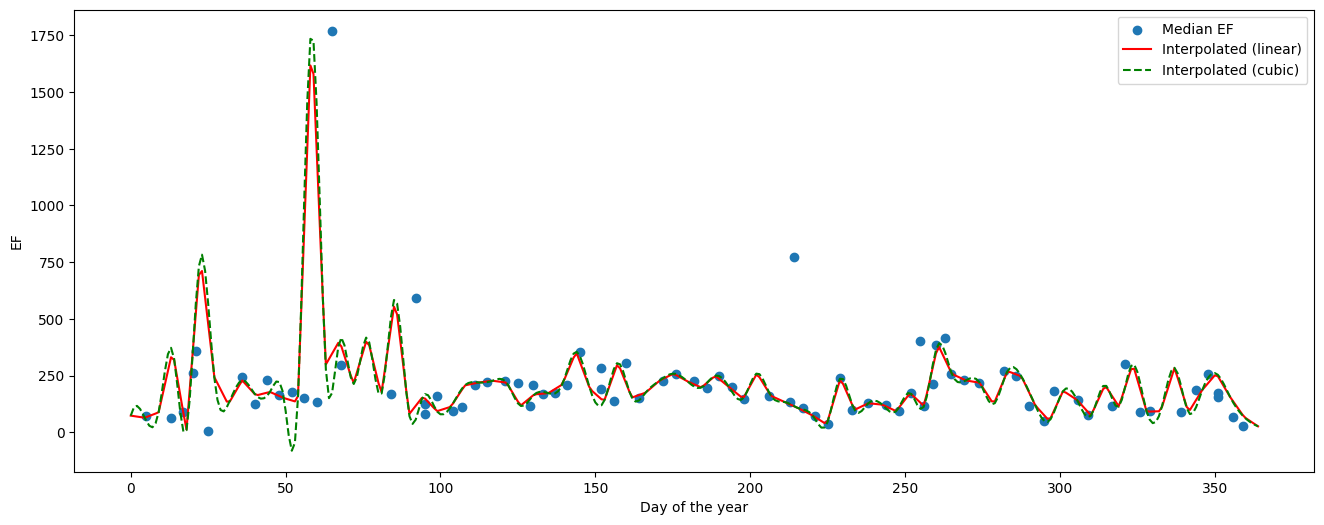

In [59]:
# Plot the interpolated EF values as a line whith linear and cubic interpolation using the function above
plt.figure(figsize=(16, 6))
plt.scatter(EF_grouped['day_of_year'], EF_grouped['EF'], label='Median EF')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='linear'), label='Interpolated (linear)', linestyle='-', color='red')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='cubic'), label='Interpolated (cubic)', linestyle='--', color='green')
plt.xlabel('Day of the year')
plt.ylabel('EF')
plt.legend()
plt.show()

### Step 2

In [60]:
filtered_T

,HYY_META.T336
Datetime,
2011-01-01 11:00:00,-7.833667
2011-01-01 14:00:00,-8.008333
2011-01-02 11:00:00,-12.427333
2011-01-02 14:00:00,-11.644333
2011-01-03 11:00:00,-12.684333
...,...
2022-12-28 14:00:00,-1.577000
2022-12-29 11:00:00,-3.503667
2022-12-29 14:00:00,-2.972667


In [61]:
# Make a day of the year (1-365) column to the filtered_T data for calculating the theoretical monoterpene flux
filtered_T['day_of_year'] = filtered_T.index.dayofyear
filtered_T

/tmp/ipykernel_46437/4019361090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['day_of_year'] = filtered_T.index.dayofyear


,HYY_META.T336,day_of_year
Datetime,,
2011-01-01 11:00:00,-7.833667,1
2011-01-01 14:00:00,-8.008333,1
2011-01-02 11:00:00,-12.427333,2
2011-01-02 14:00:00,-11.644333,2
2011-01-03 11:00:00,-12.684333,3
...,...,...
2022-12-28 14:00:00,-1.577000,362
2022-12-29 11:00:00,-3.503667,363
2022-12-29 14:00:00,-2.972667,363


In [62]:
# Create a mapping between day_of_year and interplated coefficients
coefficients_mapping = dict(zip(range(1, 366), interpolated))

In [63]:
coefficients_mapping

{1: 73.26765626865492,
 2: 71.23506917243822,
 3: 69.2024820762215,
 4: 67.1698949800048,
 5: 65.1373078837881,
 6: 66.7792932745648,
 7: 72.00622743313995,
 8: 77.2331615917151,
 9: 82.46009575029025,
 10: 88.37060239090417,
 11: 148.966907594619,
 12: 209.56321279833372,
 13: 270.1595180020485,
 14: 330.75582320576336,
 15: 319.28548410845707,
 16: 240.89611816020224,
 17: 162.5067522119474,
 18: 84.11738626369254,
 19: 11.872530008244436,
 20: 182.33580661866273,
 21: 352.799083229081,
 22: 523.2623598394986,
 23: 693.7256364499169,
 24: 711.0940244170429,
 25: 593.1692549784676,
 26: 475.24448553989225,
 27: 357.31971610131694,
 28: 242.76792564637867,
 29: 215.91358876600535,
 30: 189.0592518856319,
 31: 162.20491500525847,
 32: 135.35057812488503,
 33: 135.90608353471043,
 34: 159.51077450674865,
 35: 183.11546547878686,
 36: 206.7201564508251,
 37: 228.42323760042095,
 38: 213.52032966800095,
 39: 198.617421735581,
 40: 183.714513803161,
 41: 168.81160587074103,
 42: 164.1251128

In [64]:
filtered_T['coeff'] = filtered_T['day_of_year'].map(coefficients_mapping)
filtered_T

/tmp/ipykernel_46437/2350956377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['coeff'] = filtered_T['day_of_year'].map(coefficients_mapping)


,HYY_META.T336,day_of_year,coeff
Datetime,,,
2011-01-01 11:00:00,-7.833667,1,73.267656
2011-01-01 14:00:00,-8.008333,1,73.267656
2011-01-02 11:00:00,-12.427333,2,71.235069
2011-01-02 14:00:00,-11.644333,2,71.235069
2011-01-03 11:00:00,-12.684333,3,69.202482
...,...,...,...
2022-12-28 14:00:00,-1.577000,362,53.535638
2022-12-29 11:00:00,-3.503667,363,44.438439
2022-12-29 14:00:00,-2.972667,363,44.438439


#### E calculation

In [65]:
filtered_T['E'] = filtered_T['coeff'] / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))
filtered_T

KeyError: 'HYY_META.T168'

In [ ]:
# Merge the filtered_MT and filtered_T data sets to get the difference between the estimate and the observation
theoretical_MT = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')
theoretical_MT

,monoterpene_flux,HYY_META.T168,day_of_year,coeff,E
Datetime,,,,,
2011-03-08 11:00:00,NaN,-1.846667,67,353.319927,31.537394
2011-03-08 14:00:00,-4.22413,-0.366333,67,353.319927,36.031875
2011-03-09 11:00:00,34.33977,0.682333,68,374.714293,41.995978
2011-03-09 14:00:00,NaN,3.218500,68,374.714293,52.763985
2011-03-10 11:00:00,-2.15036,-0.054167,69,359.680663,37.725701
...,...,...,...,...,...
2022-12-28 14:00:00,-9.48310,-1.361667,362,53.060620,4.947513
2022-12-29 11:00:00,-11.67800,-3.435667,363,44.232018,3.422047
2022-12-29 14:00:00,-2.46000,-2.892500,363,44.232018,3.593490


In [ ]:
# Drop the columns that are not needed
theoretical_MT = theoretical_MT.drop(columns=['HYY_META.T168', 'day_of_year', 'coeff'])
theoretical_MT

,monoterpene_flux,E
Datetime,,
2011-03-08 11:00:00,NaN,31.537394
2011-03-08 14:00:00,-4.22413,36.031875
2011-03-09 11:00:00,34.33977,41.995978
2011-03-09 14:00:00,NaN,52.763985
2011-03-10 11:00:00,-2.15036,37.725701
...,...,...
2022-12-28 14:00:00,-9.48310,4.947513
2022-12-29 11:00:00,-11.67800,3.422047
2022-12-29 14:00:00,-2.46000,3.593490


In [ ]:
theoretical_MT.describe()

,monoterpene_flux,E
count,2932.000000,3209.000000
mean,47.022026,54.151425
std,90.575816,49.103391
min,-451.520000,0.549863
25%,3.234495,20.662269
50%,27.657080,39.160201
75%,69.988897,70.441169
max,1880.000000,391.292241


In [ ]:
# Get all monoterpene flux values which are negative
negative_MT = theoretical_MT[theoretical_MT['monoterpene_flux'] < 0]
negative_MT

,monoterpene_flux,E
Datetime,,
2011-03-08 14:00:00,-4.22413,36.031875
2011-03-10 11:00:00,-2.15036,37.725701
2011-03-10 14:00:00,-1.89731,42.832047
2011-03-11 14:00:00,-9.35496,33.720263
2011-03-12 14:00:00,-8.53581,28.415689
...,...,...
2022-12-26 14:00:00,-40.79700,4.383915
2022-12-28 11:00:00,-13.32500,4.753494
2022-12-28 14:00:00,-9.48310,4.947513


In [ ]:
theoretical_MT[theoretical_MT['E'] < 0]

,monoterpene_flux,E
Datetime,,


Ask from Ditte, that should the E (theoretical values) also have negative values?

### NEE baseline

In [ ]:
baseline_NEE = pd.read_csv('../data/hyytiala_modelfluxes_2010-2019.csv')

In [ ]:
baseline_NEE.columns

Index(['time', 'photosynthesis', 'respiration_canopy', 'respiration_trunk',
       'respiration_soil', 'relative_humidity', 'soil_moisture', 'air_temp',
       'soil_temp', 'irradiation', 'weather', 'co2', 'sample_day'],
      dtype='object')

Theretical NEE is calculated by: respiration_canopy + respiration_trunk + respiration_soil - photosynthesis

In [ ]:
# Drop the columns that are not needed
baseline_NEE = baseline_NEE.drop(columns=['relative_humidity', 'soil_moisture', 'air_temp','soil_temp', 'irradiation', 'weather', 'co2', 'sample_day'])
baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil
0,2010-01-01 00:00:00,0.0,0.000000,0.000000,0.609066
1,2010-01-01 00:30:00,0.0,0.000000,0.000000,0.606867
2,2010-01-01 01:00:00,0.0,0.000000,0.000000,0.606867
3,2010-01-01 01:30:00,0.0,0.000000,0.000000,0.606867
4,2010-01-01 02:00:00,0.0,0.000000,0.000000,0.605403
...,...,...,...,...,...
169570,2019-12-31 21:30:00,0.0,0.097098,0.032366,0.812693
169571,2019-12-31 22:00:00,0.0,0.106984,0.035661,0.812202
169572,2019-12-31 22:30:00,0.0,0.108134,0.036045,0.812202
169573,2019-12-31 23:00:00,0.0,0.108088,0.036029,0.812202


In [ ]:
# Drop the rows that have zero values in the photosynthesis, respiration_canopy,	respiration_trunk and respiration_soil
baseline_NEE = baseline_NEE[(baseline_NEE['photosynthesis'] != 0) & 
                            (baseline_NEE['respiration_canopy'] != 0) & 
                            (baseline_NEE['respiration_trunk'] != 0) & 
                            (baseline_NEE['respiration_soil'] != 0)]
baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil
493,2010-01-11 23:30:00,8.200501e-07,0.022790,0.007597,0.600709
495,2010-01-12 00:30:00,4.891754e-07,0.024962,0.008321,0.600813
496,2010-01-12 01:00:00,6.849029e-07,0.027653,0.009218,0.600918
498,2010-01-12 02:00:00,3.593141e-06,0.030007,0.010002,0.601647
500,2010-01-12 03:00:00,1.025807e-05,0.033268,0.011089,0.602063
...,...,...,...,...,...
169554,2019-12-31 13:30:00,4.086046e-01,0.168642,0.056214,0.804012
169555,2019-12-31 14:00:00,2.702518e-01,0.164384,0.054795,0.803402
169556,2019-12-31 14:30:00,1.312732e-01,0.144745,0.048248,0.804378
169557,2019-12-31 15:00:00,3.444579e-02,0.122583,0.040861,0.806208


In [ ]:
# Calculate the theoretical NEE
baseline_NEE.loc[:, 'NEE_theoretical'] = (
    baseline_NEE['respiration_canopy'] + 
    baseline_NEE['respiration_trunk'] + 
    baseline_NEE['respiration_soil'] - 
    baseline_NEE['photosynthesis']
)

baseline_NEE

/tmp/ipykernel_353627/2329654979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_NEE.loc[:, 'NEE_theoretical'] = (


,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil,NEE_theoretical
493,2010-01-11 23:30:00,8.200501e-07,0.022790,0.007597,0.600709,0.631095
495,2010-01-12 00:30:00,4.891754e-07,0.024962,0.008321,0.600813,0.634096
496,2010-01-12 01:00:00,6.849029e-07,0.027653,0.009218,0.600918,0.637787
498,2010-01-12 02:00:00,3.593141e-06,0.030007,0.010002,0.601647,0.641652
500,2010-01-12 03:00:00,1.025807e-05,0.033268,0.011089,0.602063,0.646411
...,...,...,...,...,...,...
169554,2019-12-31 13:30:00,4.086046e-01,0.168642,0.056214,0.804012,0.620263
169555,2019-12-31 14:00:00,2.702518e-01,0.164384,0.054795,0.803402,0.752329
169556,2019-12-31 14:30:00,1.312732e-01,0.144745,0.048248,0.804378,0.866097
169557,2019-12-31 15:00:00,3.444579e-02,0.122583,0.040861,0.806208,0.935206


### Combination of theoretical and measurement NEE datasets

In [ ]:
# load the observed NEE data
observed_NEE = pd.read_csv('../data/GPP_NEE_flux_2001-2022.csv')

In [ ]:
# Keep only the rows where NEE_gapfilling_method is 0
observed_NEE = observed_NEE[observed_NEE['NEE_gapfilling_method'] == 0]

In [ ]:
observed_NEE

,Unnamed: 0,Datetime,NEE,NEE_gapfilling_method,GPP
37,37,2001-01-01 18:30:00,0.150,0,0.334
45,45,2001-01-01 22:30:00,0.471,0,0.029
47,47,2001-01-01 23:30:00,0.337,0,0.164
48,48,2001-01-02 00:00:00,0.074,0,0.417
49,49,2001-01-02 00:30:00,-0.519,0,1.008
...,...,...,...,...,...
385675,385675,2022-12-31 21:30:00,2.100,0,-1.002
385676,385676,2022-12-31 22:00:00,2.588,0,-1.491
385677,385677,2022-12-31 22:30:00,2.134,0,-1.043
385678,385678,2022-12-31 23:00:00,1.260,0,-0.181


In [ ]:
# Drop the Unnamed:0, NEE_gapfillling_methdo and GPP columns
observed_NEE = observed_NEE.drop(columns=['Unnamed: 0', 'NEE_gapfilling_method', 'GPP'])
# Convert the Datetime column to datetime object and set it as index
observed_NEE['Datetime'] = pd.to_datetime(observed_NEE['Datetime'])
observed_NEE.set_index('Datetime', inplace=True)
observed_NEE

,NEE
Datetime,
2001-01-01 18:30:00,0.150
2001-01-01 22:30:00,0.471
2001-01-01 23:30:00,0.337
2001-01-02 00:00:00,0.074
2001-01-02 00:30:00,-0.519
...,...
2022-12-31 21:30:00,2.100
2022-12-31 22:00:00,2.588
2022-12-31 22:30:00,2.134


In [ ]:
# Drop the photosynthesis, respiration_canopy, respiration_trunk and respiration_soil columns from the baseline_NEE data
baseline_NEE = baseline_NEE.drop(columns=['photosynthesis', 'respiration_canopy', 'respiration_trunk', 'respiration_soil'])
# Set the time column to datetime object and set it as index
baseline_NEE['time'] = pd.to_datetime(baseline_NEE['time'])
baseline_NEE.set_index('time', inplace=True)
baseline_NEE

,NEE_theoretical
time,
2010-01-11 23:30:00,0.631095
2010-01-12 00:30:00,0.634096
2010-01-12 01:00:00,0.637787
2010-01-12 02:00:00,0.641652
2010-01-12 03:00:00,0.646411
...,...
2019-12-31 13:30:00,0.620263
2019-12-31 14:00:00,0.752329
2019-12-31 14:30:00,0.866097


In [ ]:
# Observed NEE data and baseline NEE data have different time ranges
# We need to filter the observed NEE data to match the time range of the baseline NEE data
observed_NEE = observed_NEE[(observed_NEE.index >= baseline_NEE.index[0]) & (observed_NEE.index <= baseline_NEE.index[-1])]
observed_NEE

,NEE
Datetime,
2010-01-12 15:00:00,0.264
2010-01-31 16:00:00,-0.277
2010-01-31 19:00:00,0.652
2010-01-31 19:30:00,0.739
2010-01-31 20:30:00,-0.046
...,...
2019-12-31 13:00:00,0.942
2019-12-31 13:30:00,0.729
2019-12-31 14:30:00,2.024


In [ ]:
# Merge the observed NEE data and the baseline NEE data
# If there are missing values in each data set, fill them with NaN
combined_NEE = pd.merge(baseline_NEE, observed_NEE, left_index=True, right_index=True, how='outer')
combined_NEE

,NEE_theoretical,NEE
2010-01-11 23:30:00,0.631095,NaN
2010-01-12 00:30:00,0.634096,NaN
2010-01-12 01:00:00,0.637787,NaN
2010-01-12 02:00:00,0.641652,NaN
2010-01-12 03:00:00,0.646411,NaN
...,...,...
2019-12-31 13:30:00,0.620263,0.729
2019-12-31 14:00:00,0.752329,NaN
2019-12-31 14:30:00,0.866097,2.024
2019-12-31 15:00:00,0.935206,1.628


In [ ]:
combined_NEE.describe()

,NEE_theoretical,NEE
count,107889.000000,94901.000000
mean,-2.327767,-2.205568
std,5.494001,5.181722
min,-19.047672,-24.984000
25%,-6.170656,-4.978000
50%,0.169801,-0.015000
75%,1.338686,0.995000
max,8.531268,14.828000


In [ ]:
# calculate the difference between the observed and theoretical NEE
combined_NEE['NEE_difference'] = combined_NEE['NEE'] - combined_NEE['NEE_theoretical']
combined_NEE

,NEE_theoretical,NEE,NEE_difference
2010-01-11 23:30:00,0.631095,NaN,NaN
2010-01-12 00:30:00,0.634096,NaN,NaN
2010-01-12 01:00:00,0.637787,NaN,NaN
2010-01-12 02:00:00,0.641652,NaN,NaN
2010-01-12 03:00:00,0.646411,NaN,NaN
...,...,...,...
2019-12-31 13:30:00,0.620263,0.729,0.108737
2019-12-31 14:00:00,0.752329,NaN,NaN
2019-12-31 14:30:00,0.866097,2.024,1.157903
2019-12-31 15:00:00,0.935206,1.628,0.692794


Shoould the negative differencies be dropped or set to 0?

In [ ]:
# Get the 20 biggest values of NEE_difference
combined_NEE.nlargest(20, 'NEE')

,NEE_theoretical,NEE,NEE_difference
2012-08-15 05:30:00,1.507166,14.828,13.320834
2014-07-19 06:00:00,-2.122306,14.698,16.820306
2012-07-26 01:30:00,5.118599,14.507,9.388401
2013-06-30 04:00:00,4.476274,14.040,9.563726
2013-06-22 01:00:00,4.467469,13.921,9.453531
2012-07-16 23:30:00,NaN,13.546,NaN
2013-07-01 00:30:00,NaN,13.485,NaN
2014-05-25 22:00:00,4.899523,13.469,8.569477
2018-06-28 22:00:00,4.947993,13.461,8.513007
2017-09-01 09:00:00,-1.229463,13.351,14.580463


### Save baselines to csv

In [ ]:
theoretical_MT["E"].to_csv("baseline_monoterpene.csv")

In [ ]:
combined_NEE["NEE_theoretical"].to_csv("baseline_NEE.csv")